In [ ]:
%%capture
# Here, we add an environment variable to help theano locate the BLAS libraries.
# found in ./usr/lib/x86_64-linux-gnu/libblas.so on colab
# More info at http://deeplearning.net/software/theano/troubleshooting.html
import os
os.environ["THEANO_FLAGS"] = 'blas.ldflags="-L/usr/lib/x86_64-linux-gnu/atlas -lblas"'

! pip install redis
! pip install git+https://github.com/Priesemann-Group/covid19_inference.git
! git clone https://gitlab.com/stevenhorn/covid-prevalence-estimate.git
! pip install /content/covid-prevalence-estimate
#Data
! git clone https://github.com/ishaberry/Covid19Canada.git --depth 1 --branch master --single-branch /content/Covid19Canada
! git clone https://github.com/CSSEGISandData/COVID-19.git --depth 1 --branch master --single-branch /content/COVID-19

In [ ]:
import json
import pymc3 as pm
from covid_prevalence.data import get_data
from covid_prevalence.models import PrevModel
from covid_prevalence.plots import plot_fit, plot_prevalence

In [2]:
# Load configuration and population
with open('/content/covid-prevalence-estimate/config/config.json','r') as f:
  config = json.load(f)
  
model = config['settings']['model']
settings = config['settings']
settings['model'] = model
pops = config['populations']
# filter for a single population.
pops = [p for p in config['populations'] if p['source_region'] == 'Logan' and p['source_state'] == 'West Virginia']
pop = pops[0]

INFO     [covid_prevalence.models] Building model for US - West Virginia - Logan
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid_prevalence.models] Generating dynamic prior for introduced infections (E_in_t)
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation
INFO     [covid_prevalence.models] using normal likelihood
Only 20 samples in chain.
WARNING  [pymc3] Only 20 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make 

Convergence achieved at 25200
INFO     [pymc3.variational.inference] Convergence achieved at 25200
Interrupted at 25,199 [50%]: Average Loss = 554.95
INFO     [pymc3.variational.inference] Interrupted at 25,199 [50%]: Average Loss = 554.95
Multiprocess sampling (2 chains in 2 jobs)
INFO     [pymc3] Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, E_begin, Is_begin, R_begin, Ecum_begin, Ia_begin, gamma, mus, mu, pu, pa, Ein_126, Ein_119, Ein_112, Ein_105, Ein_98, Ein_91, Ein_84, Ein_77, Ein_70, Ein_63, Ein_56, Ein_49, Ein_42, Ein_35, Ein_28, Ein_21, Ein_14, Ein_7, Ein_0, transient_len_18_log_, transient_len_17_log_, transient_len_16_log_, transient_len_15_log_, transient_len_14_log_, transient_len_13_log_, transient_len_12_log_, transient_len_11_log_, transient_len_10_log_, transient_len_9_log_, transient_len_8_log_, transient_len_7_log_, transient_len_6_log_, transient_len_5_log_, transient_len_4_log_, transient_len_3_lo

Sampling 2 chains for 20 tune and 20 draw iterations (40 + 40 draws total) took 127 seconds.
INFO     [pymc3] Sampling 2 chains for 20 tune and 20 draw iterations (40 + 40 draws total) took 127 seconds.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:603: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
INFO     [covid_prevalence.plots] Plotting Fit
INFO     [covid_prevalence.plots] Fit plot saved to /content/covid-prevalence/results/latest/USWestVirginiaLogan/USWestVirginiaLogan_fit.png


NameError: ignored

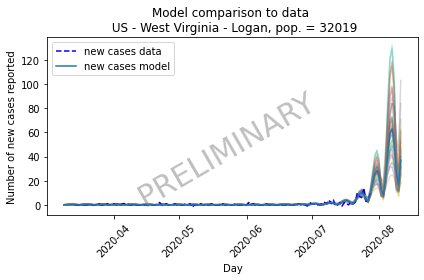

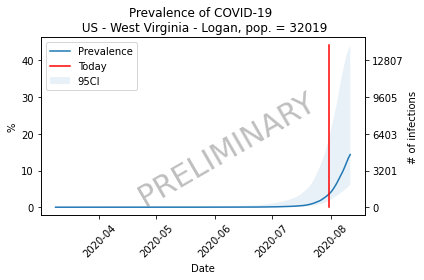

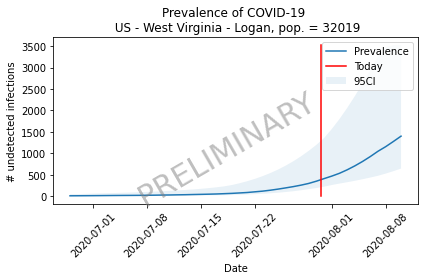

In [3]:
# Run the model on the latest data
new_cases, cum_deaths, bd = get_data(pop)

params_model = dict(
      new_cases_obs=new_cases,
      data_begin=bd,#+datetime.timedelta(days=10),
      fcast_len=14,             # forecast model
      diff_data_sim=5,     # number of days for burn-in
      N_population=pop['N'],
      settings=settings,
      pop = pop,
    )

numsims = 20#settings['numsims']
numtune = 20#settings['numtune']

# Create the model
with PrevModel(**params_model) as this_model:

  # initialize and sample the model
  trace = pm.sample(model=this_model, 
                    tune=numtune, 
                    draws=numsims, 
                    n_init=50000, 
                    init="advi+adapt_diag", 
                    cores=2, 
                    target_accept=0.85)

#with this_model:
#  pm.traceplot(trace, var_names=["pa", "pu","mu","mus", "Is_begin","Ia_begin","E_begin"])

plot_fit(this_model, trace, new_cases, pop, settings, closeplot=False, rootpath='/content')
plot_prevalence(this_model, trace, pop, settings, closeplot=False, rootpath='/content')
plot_posteriors(this_model, trace, pop, settings, closeplot=False)


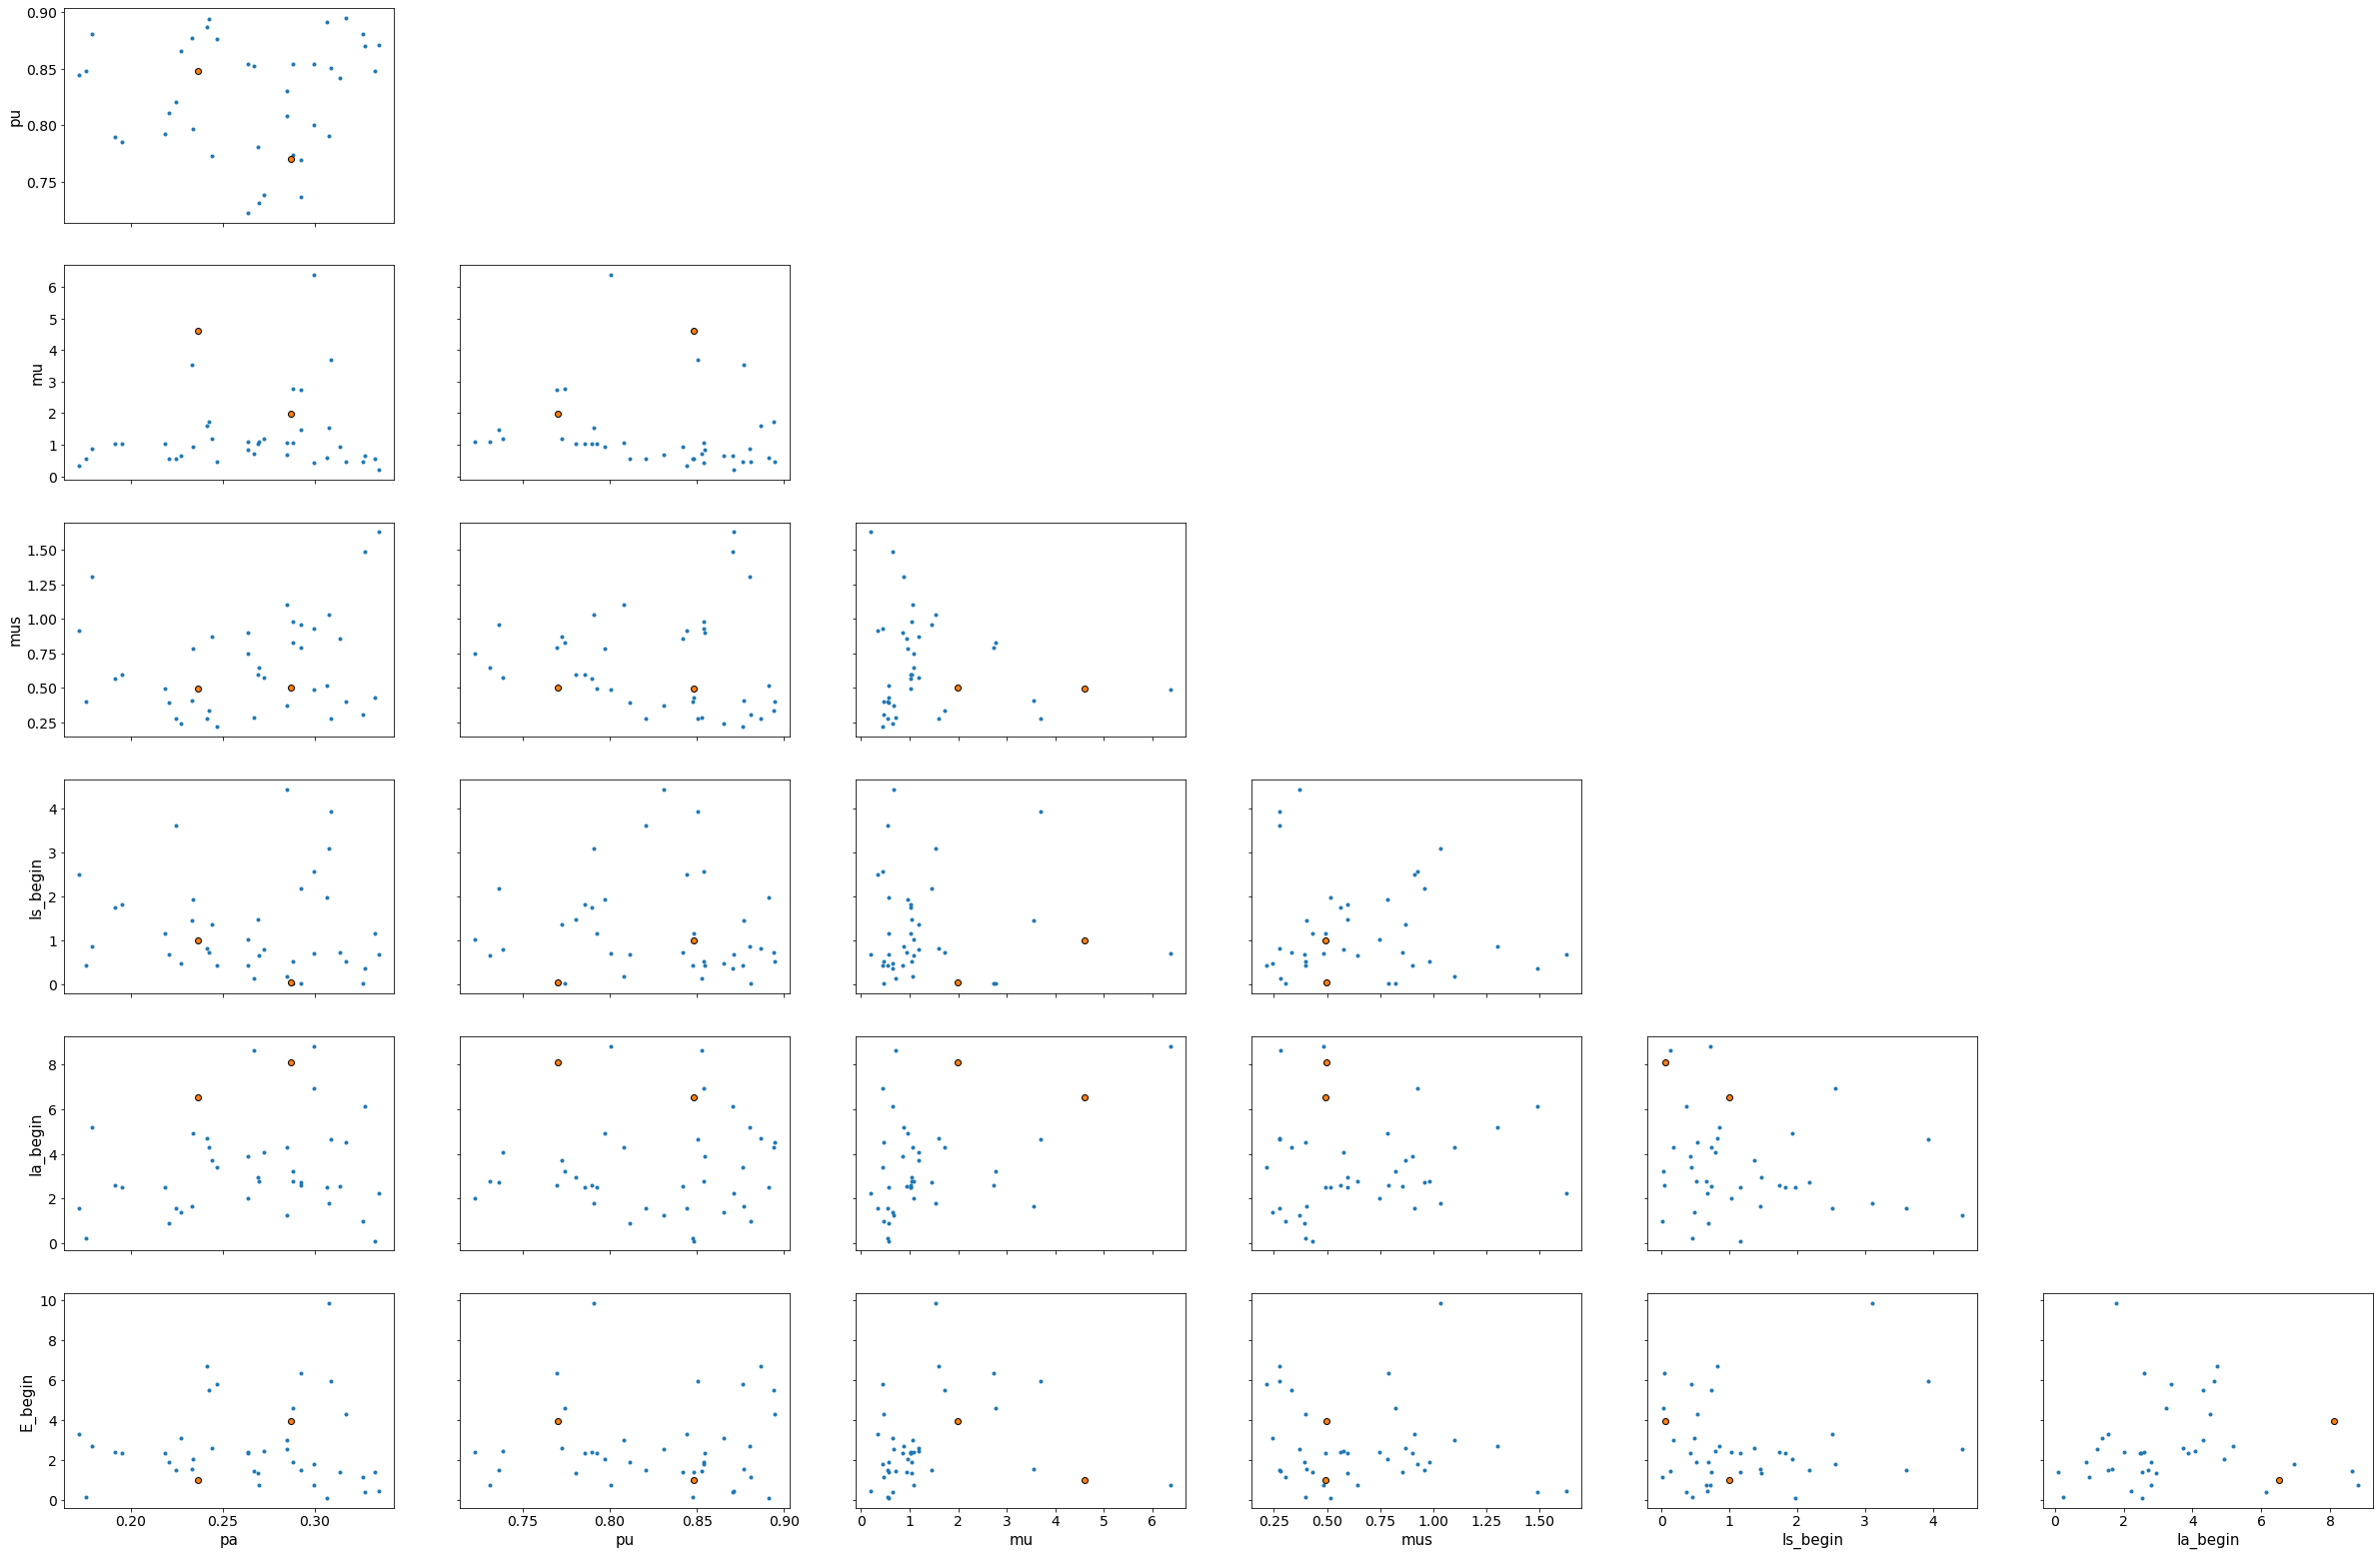

In [11]:
with this_model:
  pm.pairplot(trace, var_names=["pa", "pu","mu","mus", "Is_begin","Ia_begin","E_begin"], divergences=True);

In [13]:
with this_model:
  summary = pm.summary(trace, var_names=["pa", "pu","mu","mus", "gamma", "Is_begin","Ia_begin","E_begin"])
  print(summary)

           mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
pa        0.264  0.045   0.172    0.327  ...    58.0      64.0      23.0   1.16
pu        0.825  0.050   0.736    0.895  ...    13.0      15.0      22.0   1.07
mu        1.357  1.271   0.205    3.690  ...     8.0       5.0      17.0   1.59
mus       0.655  0.346   0.217    1.304  ...    49.0      49.0      23.0   1.02
gamma     0.387  0.218   0.099    0.756  ...    27.0      19.0      44.0   1.08
Is_begin  1.222  1.102   0.019    3.611  ...    63.0      40.0      57.0   1.04
Ia_begin  3.454  2.174   0.906    8.822  ...    26.0      19.0      22.0   1.10
E_begin   2.664  2.079   0.083    6.364  ...    15.0      22.0      25.0   1.11

[8 rows x 11 columns]
